In [1]:
import torch
import random
import random
import torch
import torch.nn as nn 
import torch.backends.cudnn as cudnn 
import torch.optim as optim
from torchvision.utils import make_grid
from backbones import get_model
from privacy_pipeline import Pipeline
import torch.nn.functional as F
import math
from IPython.display import clear_output
from IPython import display
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from IPython.display import Image as showIm
from IPython.display import display
import numpy as np
# from torchvsion.model import res

In [2]:
class DeepInversionFeatureHook():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        nch = input[0].shape[1]
        mean = input[0].mean([0, 2, 3])
        var = input[0].permute(1, 0, 2, 3).contiguous().view([nch, -1]).var(1, unbiased=False)
#         print(input[0].shape,module.running_var.shape)
        r_feature = torch.norm(module.running_var.data - var, 2) + torch.norm(
            module.running_mean.data - mean, 2)
        self.r_feature = r_feature
    def close(self):
        self.hook.remove()

In [3]:
def get_image_prior_losses(inputs_jit):
    diff1 = inputs_jit[:, :, :, :-1] - inputs_jit[:, :, :, 1:]
    diff2 = inputs_jit[:, :, :-1, :] - inputs_jit[:, :, 1:, :]
    diff3 = inputs_jit[:, :, 1:, :-1] - inputs_jit[:, :, :-1, 1:]
    diff4 = inputs_jit[:, :, :-1, :-1] - inputs_jit[:, :, 1:, 1:]

    loss_var_l2 = torch.norm(diff1) + torch.norm(diff2) + torch.norm(diff3) + torch.norm(diff4)
    loss_var_l1 = (diff1.abs() / 255.0).mean() + (diff2.abs() / 255.0).mean() + (
            diff3.abs() / 255.0).mean() + (diff4.abs() / 255.0).mean()
    loss_var_l1 = loss_var_l1 * 255.0
    return loss_var_l1, loss_var_l2

In [4]:
# 16 ,3 ,112,112
torch.norm(inputs,dim=[2,3]).sum(dim=1)

NameError: name 'inputs' is not defined

In [5]:
image_resolution = 112
do_flip = True
net = get_model('r100',fp16=False).eval().cuda()
net.load_state_dict(torch.load('/private/data/backbone.pth'));

In [6]:
r_feature_layers = [] 
for module in net.modules():
    if isinstance(module,nn.BatchNorm2d):
        r_feature_layers.append(DeepInversionFeatureHook(module))

In [7]:
def lr_policy(lr_fn):
    def _alr(optimizer, iteration, epoch):
        lr = lr_fn(iteration, epoch)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    return _alr

def lr_cosine_policy(base_lr, warmup_length, epochs):
    def _lr_fn(iteration, epoch):
        if epoch < warmup_length:
            lr = base_lr * (epoch + 1) / warmup_length
        else:
            e = epoch - warmup_length
            es = epochs - warmup_length
            lr = 0.5 * (1 + np.cos(np.pi * e / es)) * base_lr
        return lr

    return lr_policy(_lr_fn)

In [8]:
bs = 16
emb_target = torch.load('save/emb_average.pt').cuda()
emb_target = emb_target.expand(bs,-1).cuda()
# cos_loss = torch.cosine_similarity(emb_target,emb_out)
# norm_loss = ((torch.norm(emb_target,dim=1)-torch.norm(emb_out,dim=1))**2)
best_loss = 1e4

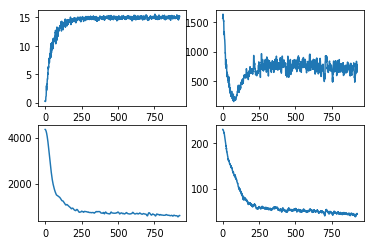

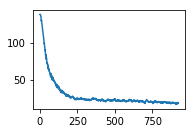

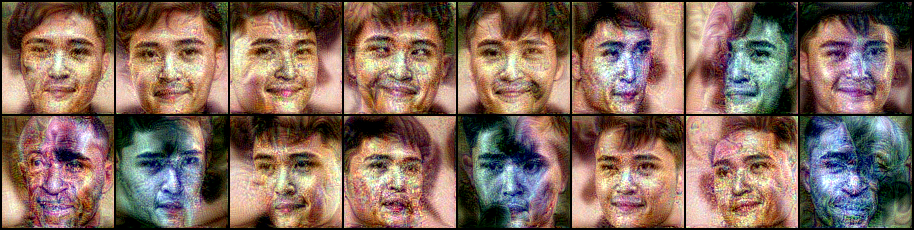

KeyboardInterrupt: 

In [9]:
stat = [[],[],[],[],[]]
emb_file = 'save/qin.pt' # 'save/emb_average.pt'
emb_target = torch.load(emb_file).cuda()
emb_target = emb_target.expand(bs,-1).cuda()
#####################
lr = 0.25
jitter = 1
epochs = 2000
c_cos,c_norm,c_bn,c_l2var = 2,0.000,0.01,0.001
flip_prob = 0.5
bn_first_scale = 10
bn_latter_scale = 0 ### not implemented
clamp = True
symmetry = False
bs = 16
start_noise = True
#####################
if not start_noise:inpu = torch.zeros((bs,3,image_resolution,image_resolution),requires_grad=True,device='cuda',dtype=torch.float)
else:inpu = torch.randn((bs,3,image_resolution,image_resolution),requires_grad=True,device='cuda',dtype=torch.float)
# optimizer = optim.Adam([inputs],lr=lr,betas=[0.5,0.9],eps=1e-8)
optimizer = optim.Adam([inpu], lr=lr, betas=(0.9,0.999), eps = 1e-8)
lr_scheduler = lr_cosine_policy(lr,100,epochs)
for epoch in range(epochs):
    lr_scheduler(optimizer, epoch,epoch)
    off1 = random.randint(-jitter,jitter)
    off2 = random.randint(-jitter,jitter)
    inputs = torch.roll(inpu, shifts=(off1,off2),dims=(2,3))

    flip = random.random() > flip_prob
    if flip and do_flip:
        inputs = torch.flip(inputs, dims=(3,))
    optimizer.zero_grad()
    net.zero_grad()
    emb_out = net(inputs)
    cos_loss = torch.cosine_similarity(emb_target,emb_out)
    norm_loss = ((torch.norm(emb_target,dim=1)-torch.norm(emb_out,dim=1))**2)
    var_l1_loss, var_l2_loss = get_image_prior_losses(inputs)
    rescale = [bn_first_scale] + [1. for _ in range(len(r_feature_layers) - 1)]
    r_feature_loss = sum([mod.r_feature * rescale[idx] for (idx,mod) in enumerate(r_feature_layers)])
    
#     l2_loss = torch.norm(inputs.view(bs,-1),dim=1).mean()
    
    loss =  -cos_loss * c_cos + \
                norm_loss * c_norm + \
                r_feature_loss * c_bn + \
            var_l2_loss * c_l2var
    
    
    loss.sum().backward()
    optimizer.step()
    with torch.no_grad():
        stat[0].append(cos_loss.sum().item())
        stat[1].append(norm_loss.sum().item())
        stat[2].append(var_l2_loss.sum().item())
        stat[3].append(r_feature_loss.sum().item())
        stat[4].append(loss.sum().item()+bs*c_cos)
        if symmetry : inputs[:] = (inputs + torch.flip(inputs,[3]))/2
#         if clamp: inputs.clamp(-1,1)
        if clamp: inputs.clamp(-1,1)
    if epoch %25 ==24:
        clear_output(wait=True)
        plt.figure(dpi=70)
        plt.subplot(221),plt.plot(stat[0]),plt.subplot(222),plt.plot(stat[1]),plt.subplot(223),plt.plot(stat[2]),plt.subplot(224),plt.plot(stat[3]),plt.show()
        plt.subplot(221), plt.plot(stat[4]), plt.show()
        save_image((inputs.data.clone()+1)/2,f'img/{epoch:04d}.png',nrow=8)
        display(showIm(filename=f'img/{epoch:04d}.png'))

In [23]:
cos_loss,norm_loss,var_l2_loss

(tensor([0.0183, 0.0024, 0.0012, 0.0266, 0.0234, 0.0038, 0.0525, 0.0358, 0.0511,
         0.0063, 0.0437, 0.0137, 0.0152, 0.0710, 0.0096, 0.0196],
        device='cuda:0', grad_fn=<DivBackward0>),
 tensor([55.2885, 66.6050, 68.7522, 60.1671, 67.5557, 61.5460, 70.8049, 57.2967,
         58.3050, 59.2275, 64.3421, 66.7510, 61.3637, 81.1190, 63.7459, 58.2089],
        device='cuda:0', grad_fn=<PowBackward0>),
 tensor(4343.7778, device='cuda:0', grad_fn=<AddBackward0>))

In [10]:
torch.argmax(cos_loss)

tensor(1, device='cuda:0')

In [ ]:
a = torch.randn(10).requires_grad_()

In [ ]:
b = a * a * a
b.backward(torch.ones(10))
a.grad

In [ ]:
emb_target = torch.rand_like(emb_target).cuda()-0.5
emb_target

In [ ]:
torch.rand_like(emb_target)-0.5

In [ ]:
f'{epoch:04d}.png'

In [ ]:
startNoise = False

In [ ]:
a = torch.arange(25).view(5,5)

In [ ]:
a

In [ ]:
a[:,1]=(a[:,1]+a[:,2]+a[:,3])/3

In [ ]:
a

In [ ]:
import torch

In [ ]:
torch.ones(1000,100,10)
torch.randn(100,100).unsqueeze(2).expand(100,100,10).shape